## Part 2: Similarity Network Fusion

In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import urllib
import urllib as ul
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import networkx as nx
import ast
from prettytable import PrettyTable
import gseapy as gp
from palettable import wesanderson

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(os.getcwd())

/Users/chaeeunlee/Documents/VSC_workspaces/ISMB_Test/Section2


In [3]:
# Define paths to .gml network files from Section 1
# These paths point to the Gene correlation network, Patient network from (1) TCGA gene expression data and (2) TCGA DNA methylation data.
G_patient_gxp_path = 'section2_data/section2_networks_v2/patient_coexpression_network_knn.gml'
G_patient_dnam_path = 'section2_data/section2_networks_v2/patient_meth_network_knn.gml'
# G_patient_gxp_path = 'section2_data/section2_networks_v1/patient_coexpression_network.gml'
# G_patient_dnam_path = 'section2_data/section2_networks_v1/patient_meth_network.gml'
G_gxp_path = 'section2_data/section2_networks_v1/gene_coexpression_network.gml'

# Load the GML graphs into NetworkX graph objects
# nx.read_gml() function reads a graph from a GML file
G_gxp = nx.read_gml(G_gxp_path)  # Gene correlation network
G_patient_gxp = nx.read_gml(G_patient_gxp_path)  # Patient gene expression network
G_patient_dnam = nx.read_gml(G_patient_dnam_path)  # Patient methylation network

# Get all nodes in each graph
# The nodes represent genes or patients depending on the network
G_gxp_nodes_list = list(G_gxp.nodes())  # Nodes in the gene correlation network
G_patient_gxp_nodes_list = list(G_patient_gxp.nodes())  # Patient nodes
G_patient_dnam_nodes_list = list(G_patient_dnam.nodes())  # Patient nodes

# Define paths to the raw TCGA datasets
tcga_dnam_path = 'section2_data/ISMB_TCGA_DNAm.pkl'  # TCGA DNA methylation data
tcga_gxp_path = 'section2_data/ISMB_TCGA_GE.pkl'  # TCGA Gene expression data

# Load the gene expression dataset
# pd.read_pickle() function loads a pickled pandas DataFrame or Series
tcga_gxp = pd.read_pickle(tcga_gxp_path)

# For this example, we'll use a CSV file that includes gene symbols
# pd.read_csv() function loads a CSV file into a pandas DataFrame
tcga_gxp_df = pd.read_csv('section2_data/tcga_ge_df_symbols_t.csv')  # Dataset with gene symbols
# Set 'GENES' column as the index for easy access to gene-specific data
tcga_gxp_df.set_index('GENES', inplace=True)

# Extract metadata from the gene expression dataset
# Metadata might include information such as patient IDs, sample conditions, etc.
tcga_gxp_meta = tcga_gxp['datMeta']

# Print the number of nodes in each network
# This provides a quick overview of the size of each network
print(f"Number of nodes in gene correlation network: {len(G_gxp_nodes_list)}")
print(f"Number of nodes in patient gene expression network: {len(G_patient_gxp_nodes_list)}")
print(f"Number of nodes in patient DNA methylation network: {len(G_patient_dnam_nodes_list)}")


Number of nodes in gene correlation network: 300
Number of nodes in patient gene expression network: 434
Number of nodes in patient DNA methylation network: 381


In [4]:
tcga_gxp_meta_dict = tcga_gxp_meta.to_dict()
print(tcga_gxp_meta_dict.keys())

dict_keys(['patient', 'race', 'gender', 'sample_type', 'cigarettes_per_day', 'Smoked', 'sizeFactor', 'replaceable'])


In [5]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def draw_network_with_node_attrs(G, node_attributes, communities=None, title='Network Visualization', color_attr=None, shape_attr=None, figsize=(20,10), layout='spring', cmap_name='tab20', with_labels=False):
    """
    Draws a graph with nodes colored by their community memberships and includes a legend indicating the community index.
    Nodes can also be colored and shaped based on additional attributes.

    Args:
        G (networkx.Graph): The graph to be drawn.
        communities (list of lists): A list where each sublist contains the nodes belonging to a community.
        node_attributes (dict): A dictionary where keys are node names and values are dictionaries of attributes.
        color_attr (str, optional): Node attribute to color by.
        shape_attr (str, optional): Node attribute to shape by.
        figsize (tuple, optional): The size of the figure. Default is (10, 10).
        layout (str, optional): The layout algorithm for positioning nodes (e.g., 'spring', 'circular'). Default is 'spring'.
        cmap_name (str, optional): The name of the colormap to use for coloring communities. Default is 'tab20'.

    Raises:
        ValueError: If the graph G is empty or not defined.
        ValueError: If the communities list is empty or not defined.
        ValueError: If node_attributes is empty or not defined.
    """
    if not G:
        raise ValueError("The graph is empty or not defined.")
    if not node_attributes:
        raise ValueError("Node attributes are empty or not defined.")

    if communities:
        community_dict = {node: idx for idx, community in enumerate(communities) for node in community}
        node_attributes['community']=community_dict
    print(f"node_attributes: {node_attributes}")
    
    shapes = ['o', '^', 's', 'p', 'h', 'H', '8', 'd', 'D', 'v', '<', '>', 'P', '*', 'X']
    cmap = plt.get_cmap(cmap_name)
    
    unique_attr_vals_color = list(set(node_attributes[color_attr].values())) if color_attr else []
    color_map = {val: cmap(i / len(unique_attr_vals_color)) for i, val in enumerate(unique_attr_vals_color)}
    
    node_colors_from_attribute = [color_map[node_attributes[color_attr][node]] for node in G.nodes()] if color_attr else ['blue']*len(list(G.nodes()))
    
    unique_attr_vals_shape = list(set(node_attributes[shape_attr].values())) if shape_attr else []
    shape_map = {val: shapes[i] for i, val in enumerate(unique_attr_vals_shape)}
    node_shapes_from_attribute = [shape_map[node_attributes[shape_attr][node]] if shape_attr else 'o' for node in G.nodes()]

    plt.figure(figsize=figsize)
    pos = getattr(nx, f'{layout}_layout')(G) if hasattr(nx, f'{layout}_layout') else nx.spring_layout(G)
    
    node_list_by_shape = {}
    node_idx_list_by_shape = {}
    for shape_marker in shapes[:len(unique_attr_vals_shape)]:
        node_list_by_shape[shape_marker] = [node for node in list(G.nodes()) if shape_map[node_attributes[shape_attr][node]] == shape_marker]
        node_idx_list_by_shape[shape_marker] = [node_idx for node_idx, node in enumerate(list(G.nodes())) if shape_map[node_attributes[shape_attr][node]] == shape_marker]
    
    for shape_marker, node_list in node_list_by_shape.items():
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=node_list_by_shape[shape_marker],
            node_color=[node_colors_from_attribute[i] for i in node_idx_list_by_shape[shape_marker]],
            node_shape=shape_marker,
            node_size=400,
            edgecolors='yellow'
        )

    nx.draw_networkx_edges(G, pos, width=0.5)
    if with_labels:
        nx.draw_networkx_labels(G, pos, font_size=12)

    legend_fontsize = 14
    # leg1=None
    if shape_attr:
        shape_legend_handles = [Line2D([0], [0], marker=shape_map[val], color='w', label=f'{val}', markerfacecolor='k', markersize=10) for val in unique_attr_vals_shape]
        leg1 = plt.legend(handles=shape_legend_handles, title=f"{shape_attr.capitalize()} (Shape)", loc='upper left', bbox_to_anchor=(1, 0.5), fontsize=legend_fontsize, title_fontsize=legend_fontsize)
    if color_attr:
        color_legend_handles = [Patch(facecolor=color_map[val], label=f'{color_attr} {val}') for val in unique_attr_vals_color]
        leg2 = plt.legend(handles=color_legend_handles, title=f"{color_attr.capitalize()} (Color)", loc='upper left', bbox_to_anchor=(1, 1), fontsize=legend_fontsize, title_fontsize=legend_fontsize)
    if shape_attr:
        plt.gca().add_artist(leg1)
    plt.title(title, fontsize=20)
    
    
    plt.show()

### 2. Patient Network Analysis

In Part 1, we worked with a gene expression network, where each node represents a gene. In Part 2, our focus shifts to Patient Networks. In patient networks, each node represents an individual patient. Unlike gene networks that represent molecular interactions, patient networks encode similarities and differences between patients, based on various modalities of data such as gene expression profiles and DNA methylation patterns.

#### 2.1 Clustering on Individual Patient Networks

We can apply clustering methods to patient networks to identify patterns in relation to a phenotypic attribute (smoking status)

In [6]:
from itertools import chain

def get_edge_attributes(G):
    """
    Extracts edge attributes from a graph.

    Args:
        G (networkx.Graph): The graph from which to extract edge attributes.

    Returns:
        list: A list of edge attributes.

    Raises:
        ValueError: If the graph G is empty or not defined.
    """
    if not G:
        raise ValueError("The graph is empty or not defined.")

    # Extract edge attributes
    edge_attributes = list(set(chain.from_iterable(d.keys() for *_, d in G.edges(data=True)))
    )
    return edge_attributes

G_gxp_weight = get_edge_attributes(G_gxp)[0]
G_patient_gxp_weight = get_edge_attributes(G_patient_gxp)[0]
G_patient_dnam_weight = get_edge_attributes(G_patient_dnam)[0]

print(f"G_gxp_weight: {G_gxp_weight}, G_patient_gxp_weight: {G_patient_gxp_weight}, G_patient_dnam_weight: {G_patient_dnam_weight}")

G_gxp_weight: weight, G_patient_gxp_weight: weight, G_patient_dnam_weight: weight


node_attributes: {'patient': {'TCGA-38-7271': 'TCGA-38-7271', 'TCGA-55-7914': 'TCGA-55-7914', 'TCGA-95-7043': 'TCGA-95-7043', 'TCGA-73-4658': 'TCGA-73-4658', 'TCGA-86-8076': 'TCGA-86-8076', 'TCGA-55-7726': 'TCGA-55-7726', 'TCGA-44-6147': 'TCGA-44-6147', 'TCGA-50-5932': 'TCGA-50-5932', 'TCGA-44-2661': 'TCGA-44-2661', 'TCGA-86-7954': 'TCGA-86-7954', 'TCGA-73-4662': 'TCGA-73-4662', 'TCGA-44-7671': 'TCGA-44-7671', 'TCGA-78-8660': 'TCGA-78-8660', 'TCGA-62-A46P': 'TCGA-62-A46P', 'TCGA-55-6978': 'TCGA-55-6978', 'TCGA-50-6592': 'TCGA-50-6592', 'TCGA-38-4625': 'TCGA-38-4625', 'TCGA-80-5611': 'TCGA-80-5611', 'TCGA-86-8054': 'TCGA-86-8054', 'TCGA-55-6986': 'TCGA-55-6986', 'TCGA-L9-A5IP': 'TCGA-L9-A5IP', 'TCGA-69-7764': 'TCGA-69-7764', 'TCGA-49-6744': 'TCGA-49-6744', 'TCGA-75-5125': 'TCGA-75-5125', 'TCGA-38-4626': 'TCGA-38-4626', 'TCGA-69-7763': 'TCGA-69-7763', 'TCGA-86-8279': 'TCGA-86-8279', 'TCGA-93-8067': 'TCGA-93-8067', 'TCGA-97-8179': 'TCGA-97-8179', 'TCGA-55-A48Y': 'TCGA-55-A48Y', 'TCGA-86-8

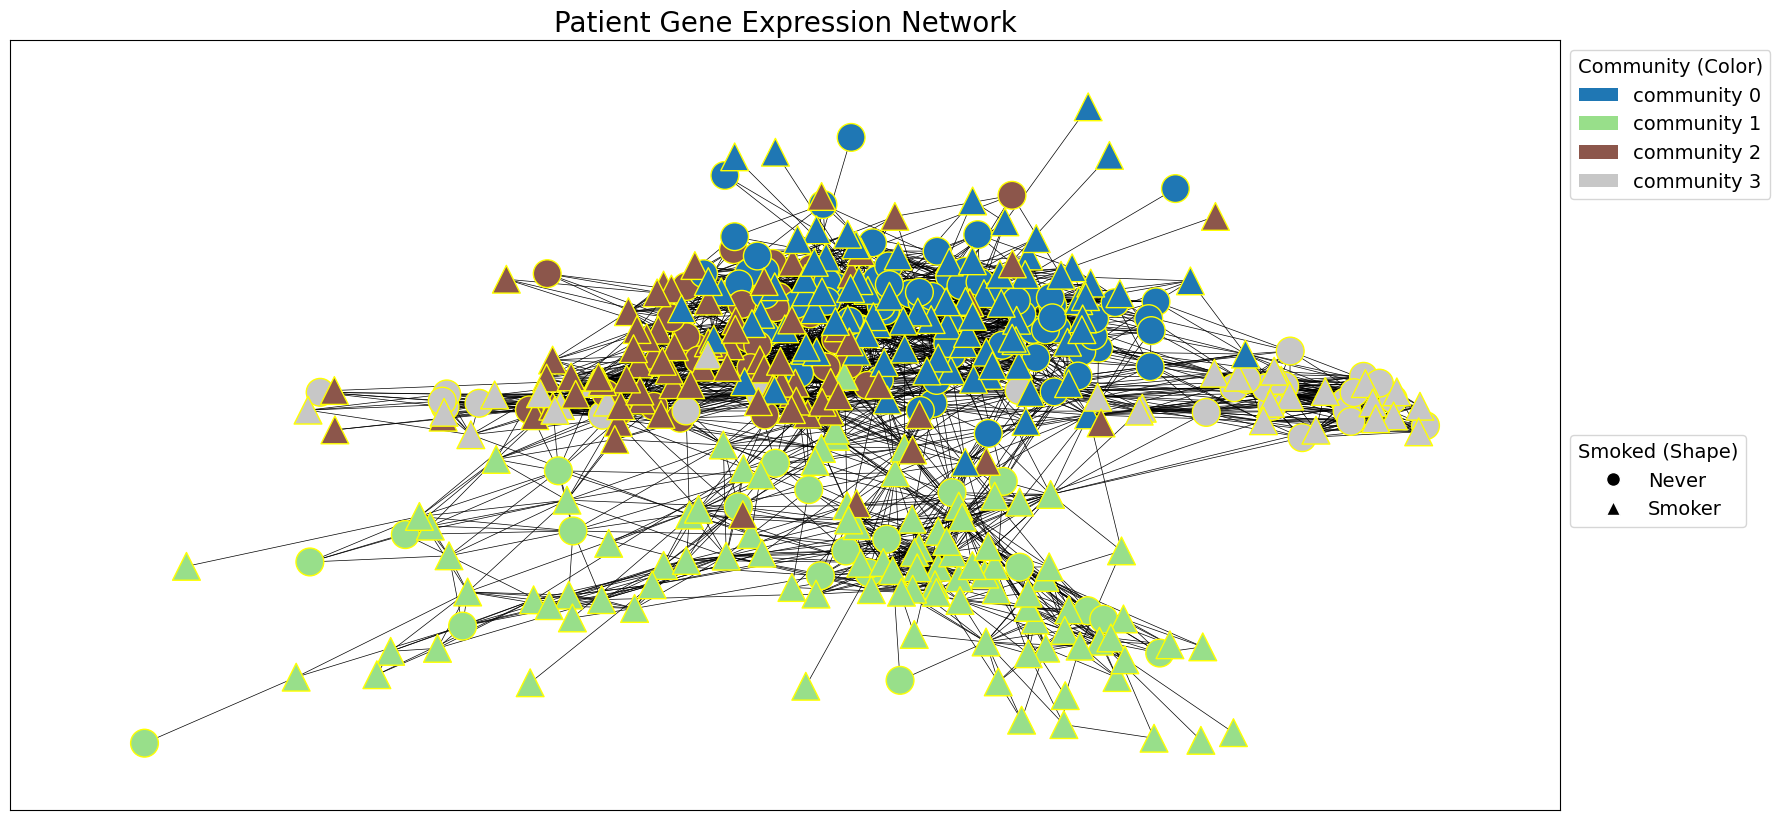

node_attributes: {'patient': {'TCGA-38-7271': 'TCGA-38-7271', 'TCGA-55-7914': 'TCGA-55-7914', 'TCGA-95-7043': 'TCGA-95-7043', 'TCGA-73-4658': 'TCGA-73-4658', 'TCGA-86-8076': 'TCGA-86-8076', 'TCGA-55-7726': 'TCGA-55-7726', 'TCGA-44-6147': 'TCGA-44-6147', 'TCGA-50-5932': 'TCGA-50-5932', 'TCGA-44-2661': 'TCGA-44-2661', 'TCGA-86-7954': 'TCGA-86-7954', 'TCGA-73-4662': 'TCGA-73-4662', 'TCGA-44-7671': 'TCGA-44-7671', 'TCGA-78-8660': 'TCGA-78-8660', 'TCGA-62-A46P': 'TCGA-62-A46P', 'TCGA-55-6978': 'TCGA-55-6978', 'TCGA-50-6592': 'TCGA-50-6592', 'TCGA-38-4625': 'TCGA-38-4625', 'TCGA-80-5611': 'TCGA-80-5611', 'TCGA-86-8054': 'TCGA-86-8054', 'TCGA-55-6986': 'TCGA-55-6986', 'TCGA-L9-A5IP': 'TCGA-L9-A5IP', 'TCGA-69-7764': 'TCGA-69-7764', 'TCGA-49-6744': 'TCGA-49-6744', 'TCGA-75-5125': 'TCGA-75-5125', 'TCGA-38-4626': 'TCGA-38-4626', 'TCGA-69-7763': 'TCGA-69-7763', 'TCGA-86-8279': 'TCGA-86-8279', 'TCGA-93-8067': 'TCGA-93-8067', 'TCGA-97-8179': 'TCGA-97-8179', 'TCGA-55-A48Y': 'TCGA-55-A48Y', 'TCGA-86-8

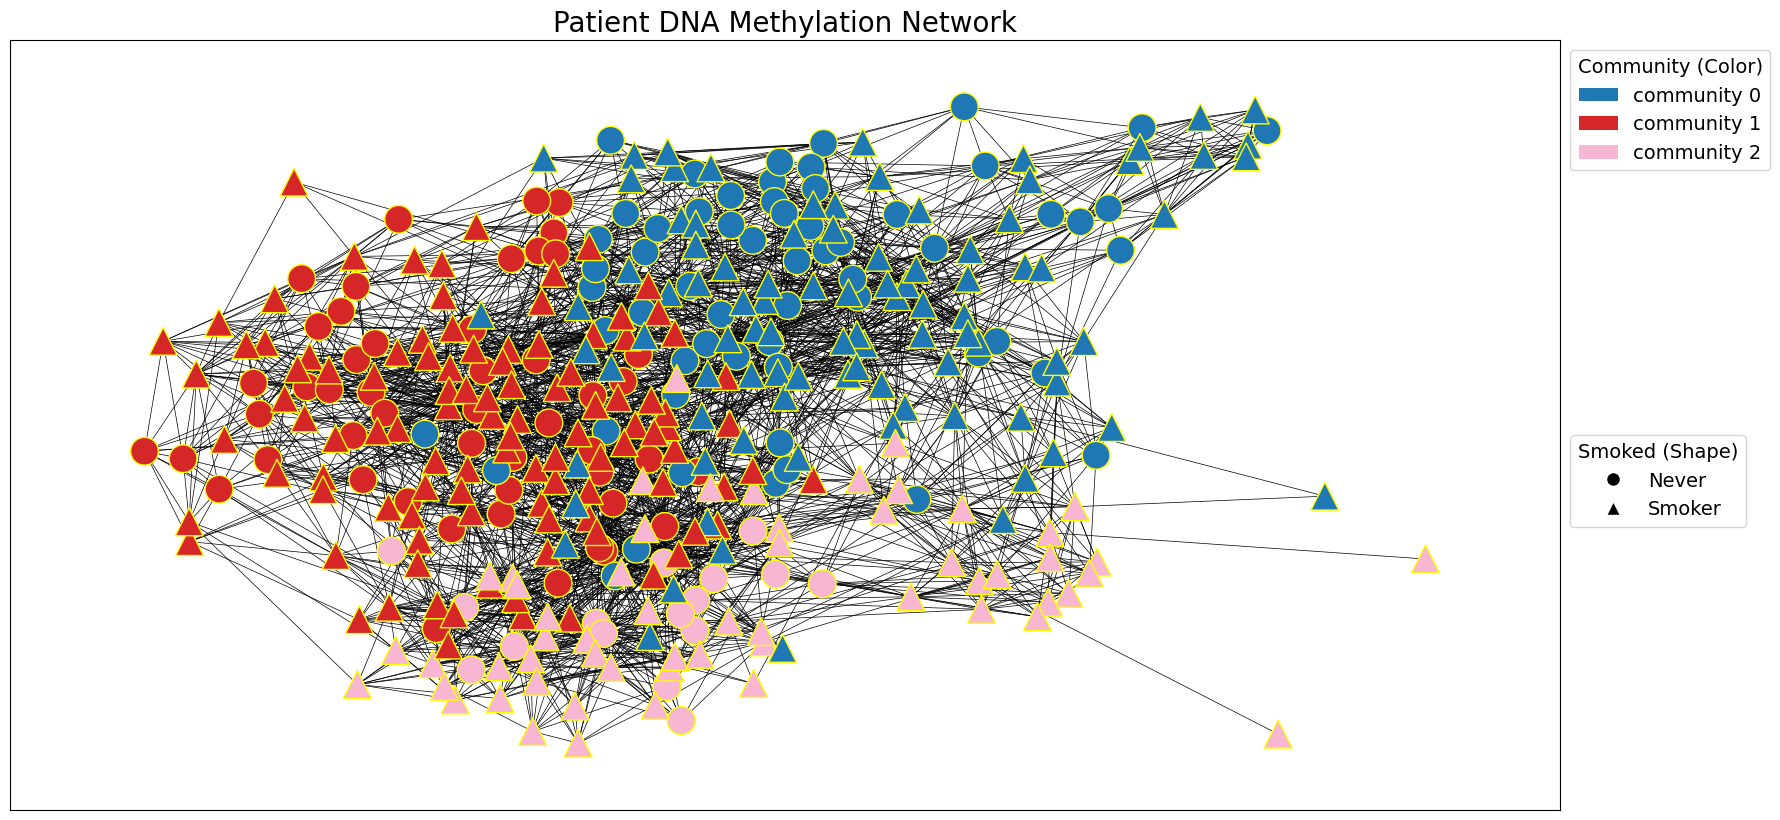

In [7]:
# Use the greedy modularity maximization method to detect communities in the patient network.
patient_gxp_communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_patient_gxp) # , weight=G_patient_gxp_weight)
patient_dnam_communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_patient_dnam) #, weight=G_patient_dnam_weight)

# Visualize the patient network with identified communities.
draw_network_with_node_attrs(G_patient_gxp, tcga_gxp_meta_dict, title='Patient Gene Expression Network', communities=patient_gxp_communities, color_attr='community', shape_attr='Smoked', layout='spring', with_labels=False)
draw_network_with_node_attrs(G_patient_dnam, tcga_gxp_meta_dict, title='Patient DNA Methylation Network', communities=patient_dnam_communities, color_attr='community', shape_attr='Smoked', layout='spring', with_labels=False)

#### 2.2 Similarity Network Fusion (SNF)

(https://pubmed.ncbi.nlm.nih.gov/24464287/)

In Patient Network analysis, we often want to combine patient data based on multiple modalities. Similarity network fusion (SNF) uses networks of patients as a basis for integration between multiple modalities. SNF consists of two main steps: 

1. Construction of a sample-similarity network for each data type 

2. Integration of these networks into a single similarity network using a nonlinear combination method.

In [8]:
def get_k_neighbors(matrix, k):
    """
    Calculates the k-nearest neighbors for each node based on a provided adjacency matrix or similarity matrix.

    Parameters:
    - matrix: A pandas DataFrame where each row and column represents a node, and the cell values represent 
      the similarity or connection strength between nodes.
    - k: Integer, the number of nearest neighbors to identify for each node.

    Returns:
    - k_neighbors: Dictionary with node identifiers as keys and a list of their k-nearest neighbors as values.
    """

    # Initialize an empty dictionary to store the neighbors of each node
    k_neighbors = {}
    
    # Iterate over each node (index of the DataFrame)
    for node in matrix.index:
        # Obtain the k + 1 largest values' indices because the largest will be the node itself
        neighbors = matrix.loc[node].nlargest(k + 1).index.tolist()[1:]  # Exclude the node itself by skipping the first index
        # Store the neighbors in the dictionary
        k_neighbors[node] = neighbors
    
    # Return the dictionary containing each node's k-nearest neighbors
    return k_neighbors


We use the Python library `snfpy` (https://github.com/rmarkello/snfpy) for similarity network fusion (SNF). We perform K-nearest neighbors procedure on each adjacency matrices to create and fuse similarity networks. 

In [9]:
import snf

In [10]:
# Get overlapping patient nodes from the two patient networks
# In patient networks, the nodes represent patients. We want to ensure that there are sufficient number of nodes commonly found in the networks of different modalities before Similarity Network Fusion (SNF), so that they represent different aspects of the same patients.
all_idx = list(set(G_patient_gxp_nodes_list) & set(G_patient_dnam_nodes_list))

# Create adjacency matrix for G_patient_gxp with overlapping nodes
G_patient_gxp_adj_matrix = nx.to_pandas_adjacency(G_patient_gxp, nodelist=all_idx, weight=G_patient_gxp_weight)

# Create adjacency matrix for G_patient_dnam with overlapping nodes
G_patient_dnam_adj_matrix = nx.to_pandas_adjacency(G_patient_dnam, nodelist=all_idx, weight=G_patient_dnam_weight)

In [11]:
len(all_idx)

381

In [12]:
print(all_idx)

['TCGA-67-6215', 'TCGA-50-5072', 'TCGA-49-4488', 'TCGA-69-7764', 'TCGA-55-8508', 'TCGA-MP-A4SW', 'TCGA-05-5425', 'TCGA-97-8552', 'TCGA-62-A472', 'TCGA-NJ-A4YP', 'TCGA-44-6774', 'TCGA-55-7227', 'TCGA-L9-A443', 'TCGA-38-7271', 'TCGA-38-4632', 'TCGA-44-7661', 'TCGA-55-8513', 'TCGA-75-6206', 'TCGA-93-A4JO', 'TCGA-64-5774', 'TCGA-44-7662', 'TCGA-55-7910', 'TCGA-93-7347', 'TCGA-55-A493', 'TCGA-78-7220', 'TCGA-MP-A4T9', 'TCGA-75-5146', 'TCGA-50-5049', 'TCGA-91-6831', 'TCGA-44-2666', 'TCGA-67-4679', 'TCGA-MP-A4TC', 'TCGA-80-5608', 'TCGA-49-AAR4', 'TCGA-05-4425', 'TCGA-50-6593', 'TCGA-97-8176', 'TCGA-MP-A4TD', 'TCGA-78-7150', 'TCGA-44-6144', 'TCGA-80-5607', 'TCGA-99-AA5R', 'TCGA-86-A4JF', 'TCGA-53-7813', 'TCGA-05-4417', 'TCGA-99-8033', 'TCGA-55-A57B', 'TCGA-55-6969', 'TCGA-99-8025', 'TCGA-MP-A4TA', 'TCGA-97-7552', 'TCGA-50-5933', 'TCGA-50-5044', 'TCGA-78-7162', 'TCGA-38-A44F', 'TCGA-69-7979', 'TCGA-55-8507', 'TCGA-50-5944', 'TCGA-78-7540', 'TCGA-86-7954', 'TCGA-86-8280', 'TCGA-93-A4JN', 'TCGA-9

In [13]:
full_graphs = [] # list of adjacency (similarity) matrices
full_graphs.append(G_patient_gxp_adj_matrix)
full_graphs.append(G_patient_dnam_adj_matrix) 

In [14]:
# Set the number of nearest neighbors and the number of iterations for SNF
k = 12
cutoff_weight = 0.003 # number of communities depends a lot on the cutoff value. or we can specify n. 

# Perform Similarity Network Fusion (SNF) on the list of adjacency matrices
# 'K' is the number of nearest neighbors used in SNF, 't' is the number of iterations
adj = snf.snf(full_graphs, K=k, t=10)

# Convert the resulting SNF matrix back into a pandas DataFrame for easier manipulation
adj_snf = pd.DataFrame(data=adj, index=all_idx, columns=all_idx)   
# Convert the DataFrame to a NumPy array
adj_snf_data = adj_snf.values
np.fill_diagonal(adj_snf_data, 0)
# print(adj_snf_data)

# Convert the adjacency matrix to a NetworkX graph
G_snf = nx.from_numpy_array(adj_snf_data)
# Set the node labels using the DataFrame index
G_snf = nx.relabel_nodes(G_snf, dict(enumerate(adj_snf.index)))

# Remove edges with weight under cutoff value
edges_to_remove = [(u, v) for u, v, d in G_snf.edges(data=True) if d['weight'] < cutoff_weight]
G_snf.remove_edges_from(edges_to_remove)


node_attributes: {'patient': {'TCGA-38-7271': 'TCGA-38-7271', 'TCGA-55-7914': 'TCGA-55-7914', 'TCGA-95-7043': 'TCGA-95-7043', 'TCGA-73-4658': 'TCGA-73-4658', 'TCGA-86-8076': 'TCGA-86-8076', 'TCGA-55-7726': 'TCGA-55-7726', 'TCGA-44-6147': 'TCGA-44-6147', 'TCGA-50-5932': 'TCGA-50-5932', 'TCGA-44-2661': 'TCGA-44-2661', 'TCGA-86-7954': 'TCGA-86-7954', 'TCGA-73-4662': 'TCGA-73-4662', 'TCGA-44-7671': 'TCGA-44-7671', 'TCGA-78-8660': 'TCGA-78-8660', 'TCGA-62-A46P': 'TCGA-62-A46P', 'TCGA-55-6978': 'TCGA-55-6978', 'TCGA-50-6592': 'TCGA-50-6592', 'TCGA-38-4625': 'TCGA-38-4625', 'TCGA-80-5611': 'TCGA-80-5611', 'TCGA-86-8054': 'TCGA-86-8054', 'TCGA-55-6986': 'TCGA-55-6986', 'TCGA-L9-A5IP': 'TCGA-L9-A5IP', 'TCGA-69-7764': 'TCGA-69-7764', 'TCGA-49-6744': 'TCGA-49-6744', 'TCGA-75-5125': 'TCGA-75-5125', 'TCGA-38-4626': 'TCGA-38-4626', 'TCGA-69-7763': 'TCGA-69-7763', 'TCGA-86-8279': 'TCGA-86-8279', 'TCGA-93-8067': 'TCGA-93-8067', 'TCGA-97-8179': 'TCGA-97-8179', 'TCGA-55-A48Y': 'TCGA-55-A48Y', 'TCGA-86-8

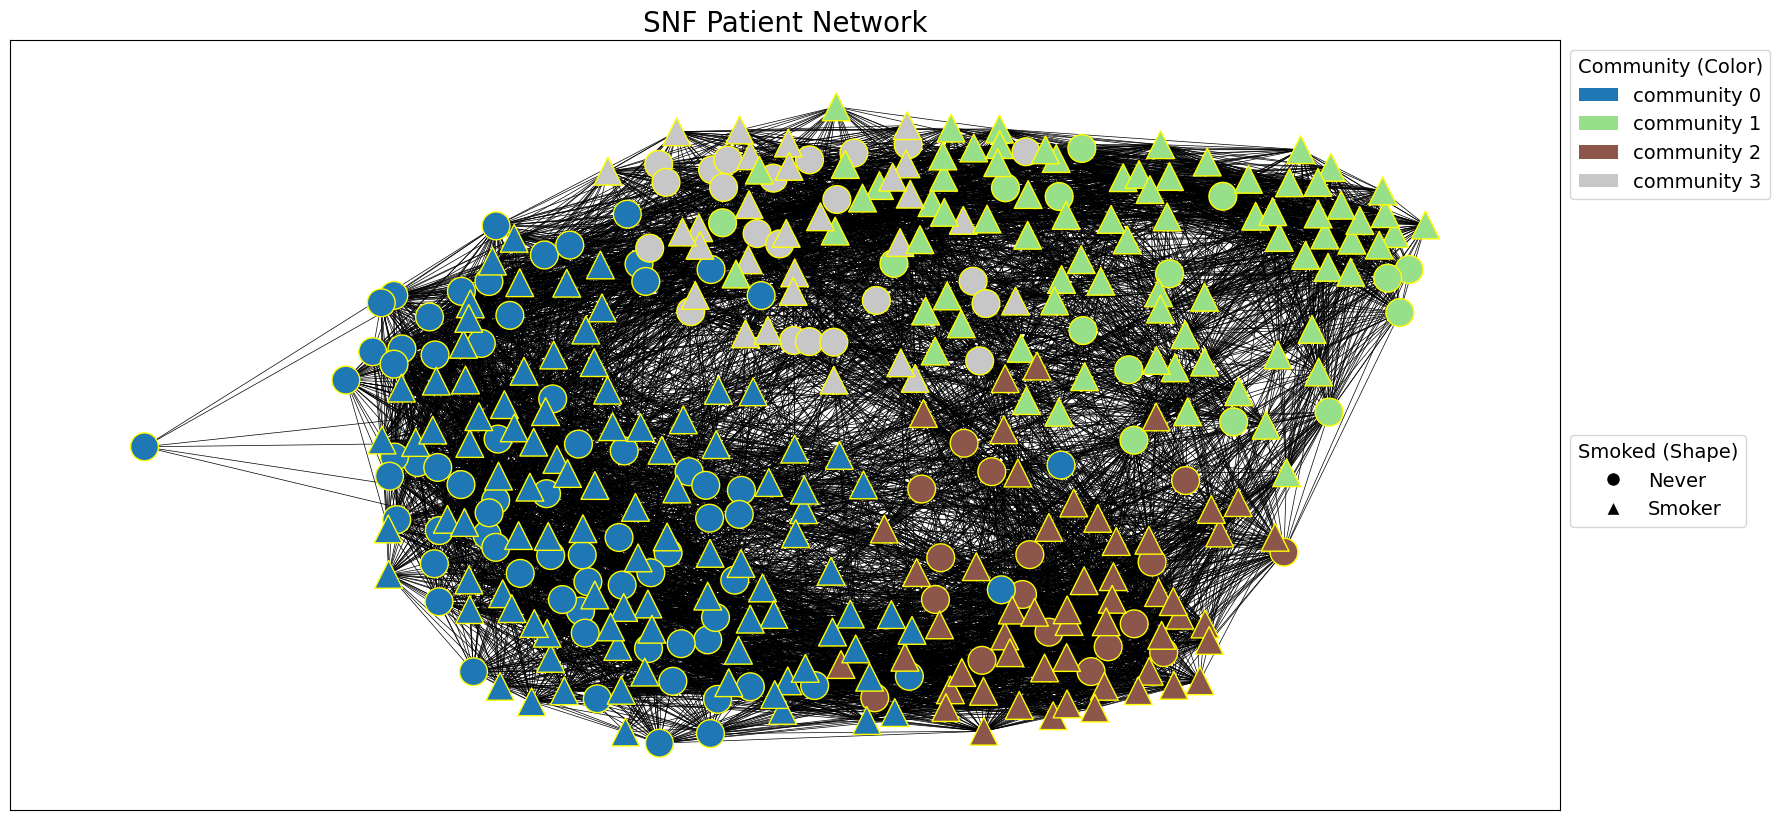

In [15]:
snf_communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_snf, weight='weight')
draw_network_with_node_attrs(G_snf, node_attributes=tcga_gxp_meta_dict, title='SNF Patient Network', communities=snf_communities, color_attr='community', shape_attr='Smoked', layout='spring', with_labels=False)

In [16]:
# Compute the k-nearest neighbors for the nodes in the network
k_neighbors = get_k_neighbors(adj_snf, k)
print(f"k_neighbors: {k_neighbors}")

# Create a new NetworkX graph
G_snf_knn = nx.Graph()
G_snf_knn.add_nodes_from(adj_snf.index)

# Add edges between each node and its k-nearest neighbors
for node, neighbors in k_neighbors.items():
    for neighbor in neighbors:
        G_snf_knn.add_edge(node, neighbor)

k_neighbors: {'TCGA-67-6215': ['TCGA-62-A46U', 'TCGA-NJ-A7XG', 'TCGA-50-8460', 'TCGA-L9-A50W', 'TCGA-86-7714', 'TCGA-50-5942', 'TCGA-44-2666', 'TCGA-55-8090', 'TCGA-67-6216', 'TCGA-78-7158', 'TCGA-91-A4BD', 'TCGA-NJ-A4YG'], 'TCGA-50-5072': ['TCGA-78-7150', 'TCGA-78-7220', 'TCGA-55-8505', 'TCGA-49-6742', 'TCGA-78-7166', 'TCGA-05-4396', 'TCGA-49-4514', 'TCGA-75-7027', 'TCGA-62-8398', 'TCGA-93-8067', 'TCGA-78-7160', 'TCGA-50-5936'], 'TCGA-49-4488': ['TCGA-62-A46R', 'TCGA-44-8117', 'TCGA-64-5778', 'TCGA-50-5066', 'TCGA-49-AARO', 'TCGA-55-7907', 'TCGA-75-6207', 'TCGA-95-7039', 'TCGA-75-5125', 'TCGA-L9-A8F4', 'TCGA-99-8025', 'TCGA-95-8494'], 'TCGA-69-7764': ['TCGA-75-6206', 'TCGA-78-7167', 'TCGA-86-7713', 'TCGA-78-7633', 'TCGA-78-7149', 'TCGA-97-8174', 'TCGA-86-8281', 'TCGA-55-A492', 'TCGA-73-7498', 'TCGA-MP-A5C7', 'TCGA-78-7537', 'TCGA-05-4384'], 'TCGA-55-8508': ['TCGA-MP-A4TE', 'TCGA-55-7910', 'TCGA-78-7159', 'TCGA-86-8054', 'TCGA-05-4390', 'TCGA-69-7973', 'TCGA-50-7109', 'TCGA-53-7813', '

node_attributes: {'patient': {'TCGA-38-7271': 'TCGA-38-7271', 'TCGA-55-7914': 'TCGA-55-7914', 'TCGA-95-7043': 'TCGA-95-7043', 'TCGA-73-4658': 'TCGA-73-4658', 'TCGA-86-8076': 'TCGA-86-8076', 'TCGA-55-7726': 'TCGA-55-7726', 'TCGA-44-6147': 'TCGA-44-6147', 'TCGA-50-5932': 'TCGA-50-5932', 'TCGA-44-2661': 'TCGA-44-2661', 'TCGA-86-7954': 'TCGA-86-7954', 'TCGA-73-4662': 'TCGA-73-4662', 'TCGA-44-7671': 'TCGA-44-7671', 'TCGA-78-8660': 'TCGA-78-8660', 'TCGA-62-A46P': 'TCGA-62-A46P', 'TCGA-55-6978': 'TCGA-55-6978', 'TCGA-50-6592': 'TCGA-50-6592', 'TCGA-38-4625': 'TCGA-38-4625', 'TCGA-80-5611': 'TCGA-80-5611', 'TCGA-86-8054': 'TCGA-86-8054', 'TCGA-55-6986': 'TCGA-55-6986', 'TCGA-L9-A5IP': 'TCGA-L9-A5IP', 'TCGA-69-7764': 'TCGA-69-7764', 'TCGA-49-6744': 'TCGA-49-6744', 'TCGA-75-5125': 'TCGA-75-5125', 'TCGA-38-4626': 'TCGA-38-4626', 'TCGA-69-7763': 'TCGA-69-7763', 'TCGA-86-8279': 'TCGA-86-8279', 'TCGA-93-8067': 'TCGA-93-8067', 'TCGA-97-8179': 'TCGA-97-8179', 'TCGA-55-A48Y': 'TCGA-55-A48Y', 'TCGA-86-8

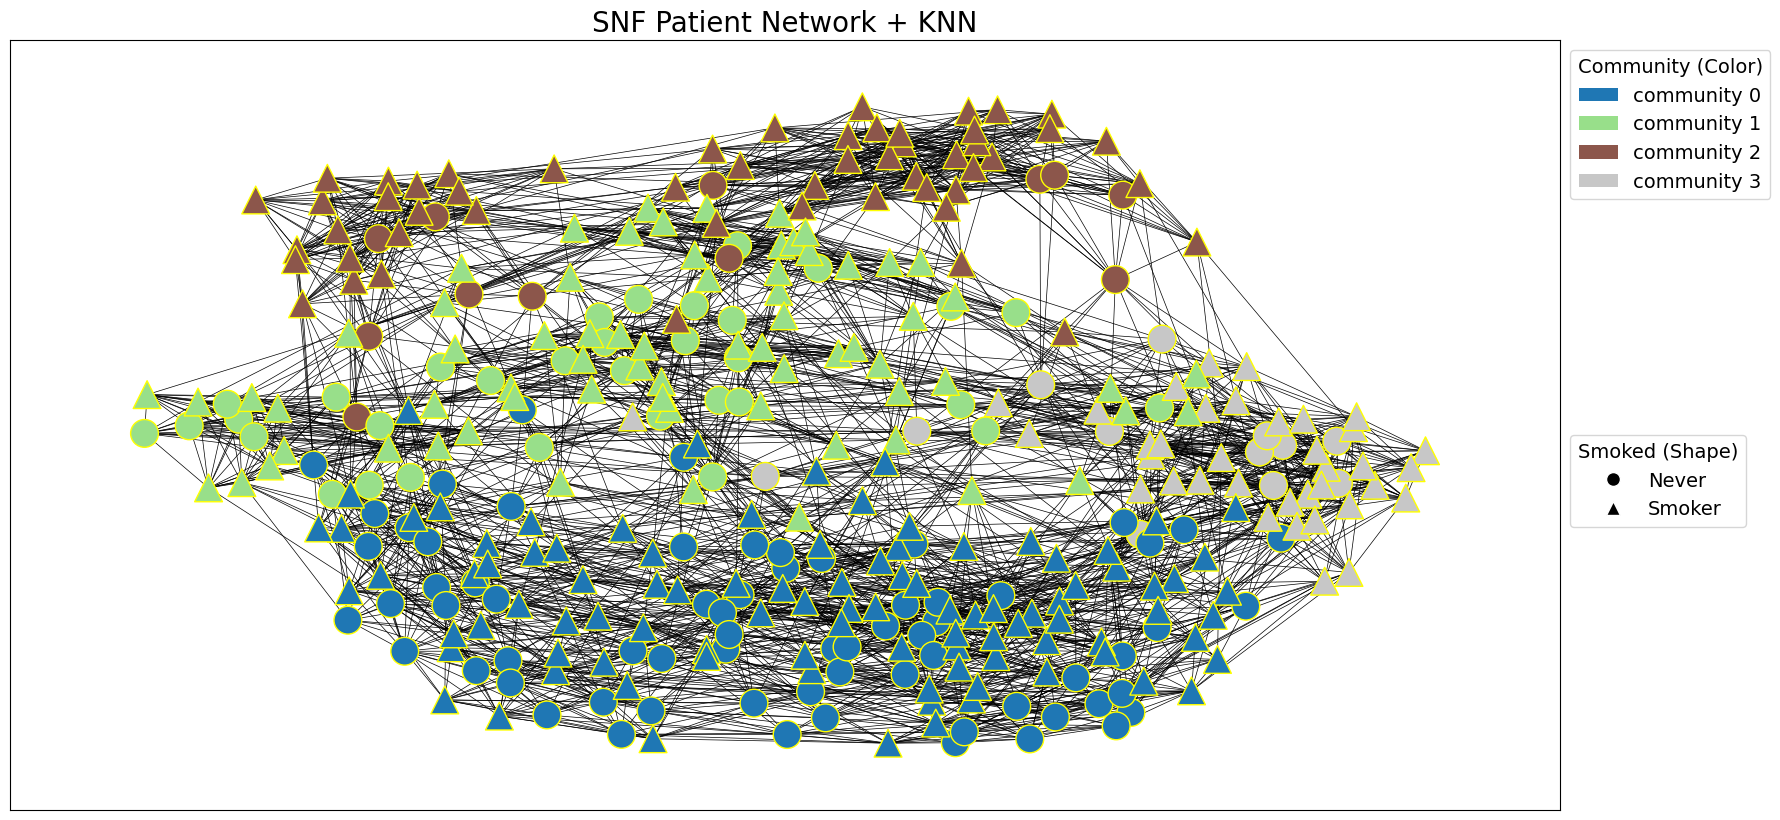

In [17]:
snf_knn_communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_snf_knn) # , weight='weight')
draw_network_with_node_attrs(G_snf_knn, node_attributes=tcga_gxp_meta_dict, title='SNF Patient Network + KNN', communities=snf_knn_communities, color_attr='community', shape_attr='Smoked', layout='spring', with_labels=False)